In [1]:
import argparse
import matplotlib.pyplot as plt
import numpy as np
import torch
from torch.utils.data import Dataset, DataLoader, Subset
from torchinfo import summary
from torchvision import transforms

from dataset.data_path import KITTI_DEP_TRAIN_RGB_PATHS, KITTI_DEP_TRAIN_LABEL_PATHS, \
    KITTI_SEM_TRAIN_RGB_PATHS, KITTI_SEM_TRAIN_LABEL_PATHS
from dataset.kitti import KITTI_DEP, KITTI_SEM
from models.regseg_model import ProbedDualTaskSeg, ConvProbe, \
                                DepthWiseSeparableConv2d, DepthWiseSeparableConvProbe, \
                                DualTaskSeg
from models.unet import UNet, DualTaskUNet
from models.deeplab import DualTaskASPP
from models.model_utils import showRegSegModelInference, showSegModelInference
from train_mult import trainDual, trainSeg

finished


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


train dataloader lengths 25
shapes (240, 360, 3) (240, 360) (376, 1241, 3) (376, 1241) (240, 360, 3)
[   1    2    3 ... 1134 1135 1136]
color [141 167 217]


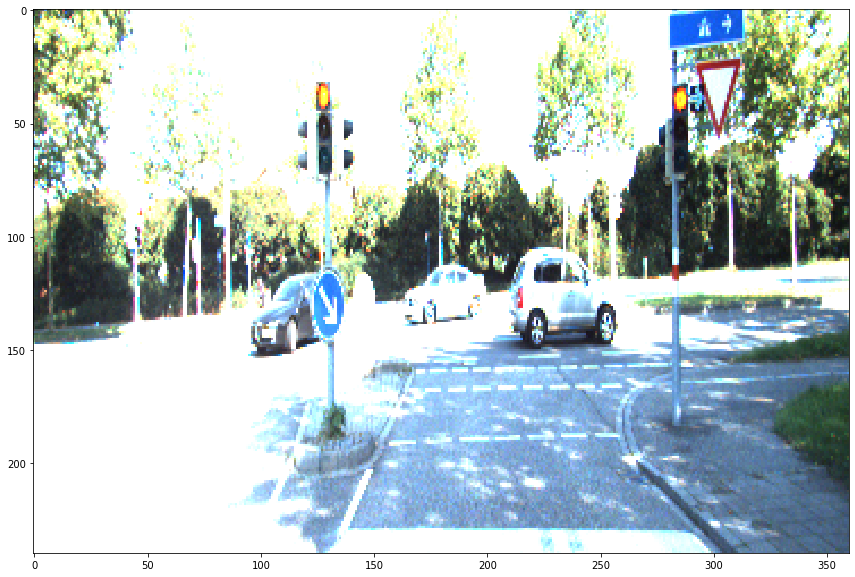

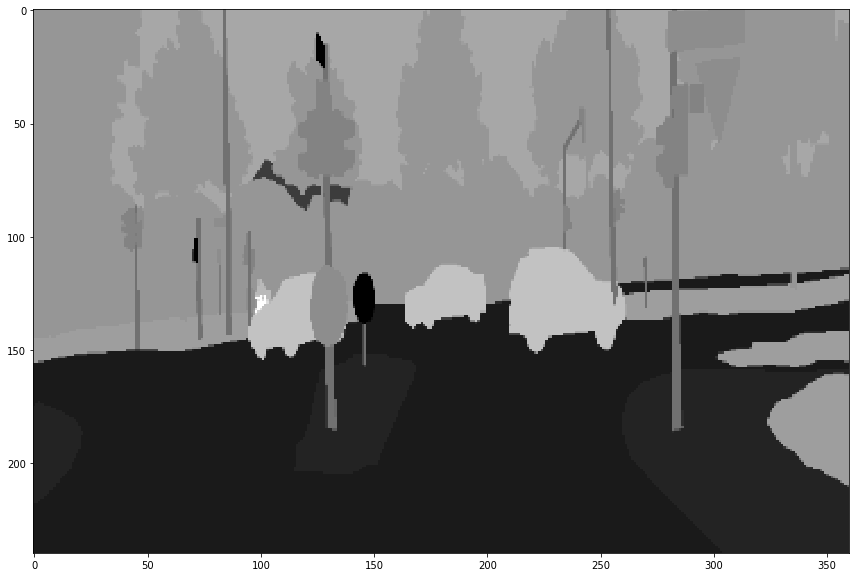

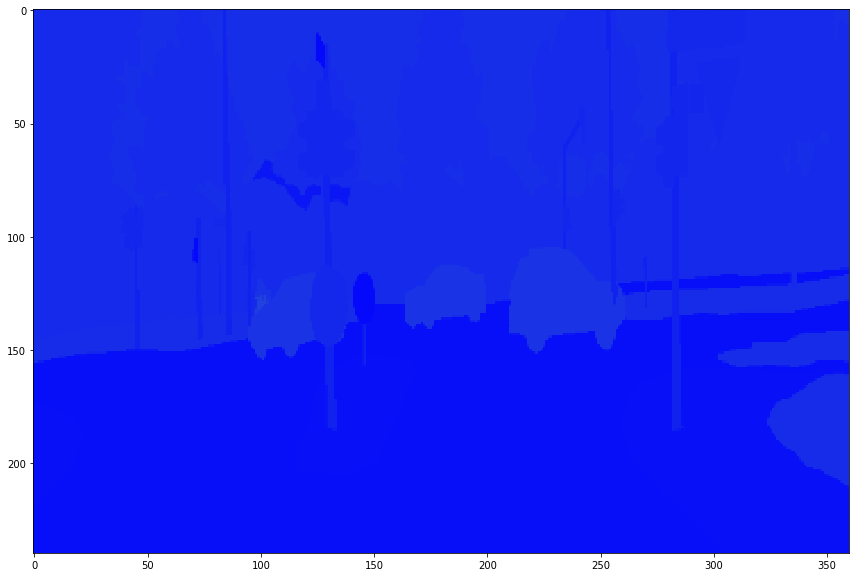

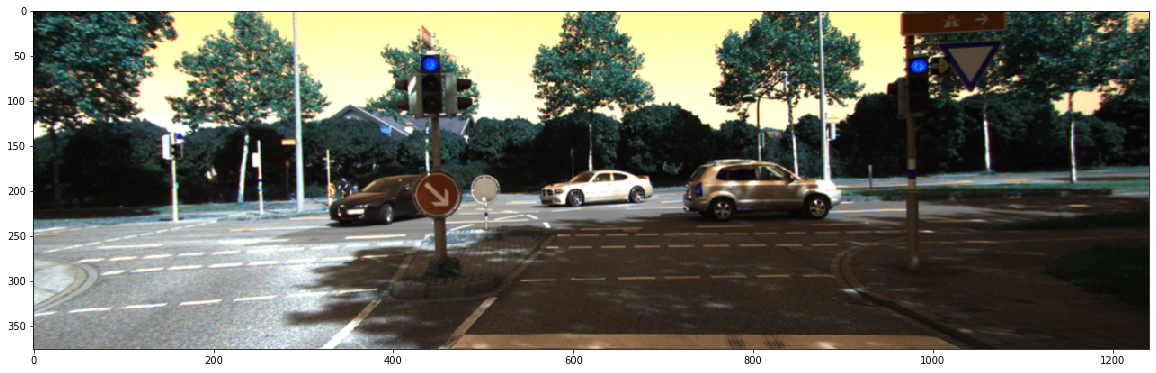

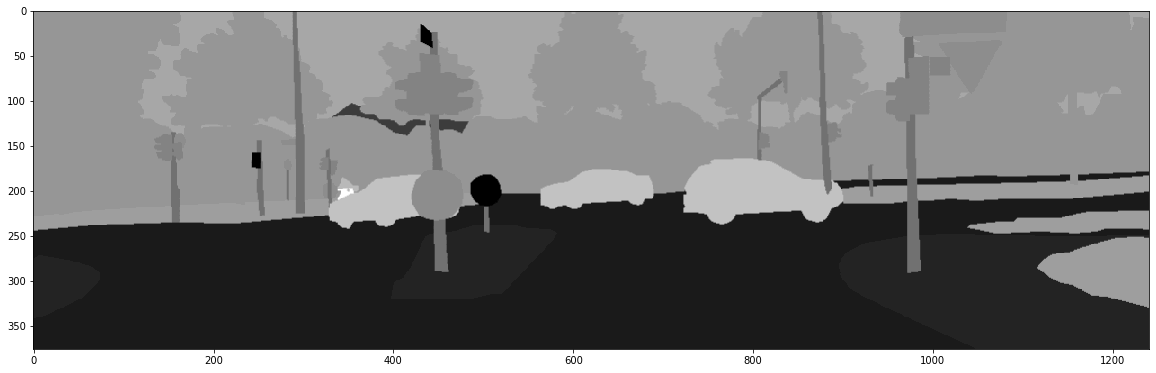

In [2]:
model_device = torch.device("cuda")
data_device = torch.device("cpu")

rgb_preprocess = transforms.Compose([
#     transforms.ToTensor(),
    transforms.Resize((240, 360)),
#     transforms.ColorJitter(0.1, 0.1, 0.1, 0.1),
#     transforms.RandomHorizontalFlip(p=0.5),
#     transforms.RandomSolarize(threshold=180, p=0.1),
    transforms.Normalize((0.485, 0.456, 0.406), (0.229, 0.224, 0.225))
])
label_preprocess2 = transforms.Compose([transforms.Resize( (240, 360) )])

seg_dataset = KITTI_SEM(KITTI_SEM_TRAIN_RGB_PATHS, KITTI_SEM_TRAIN_LABEL_PATHS, device=data_device,
                        transform=rgb_preprocess, target_transform=label_preprocess2, original=True)
SPLIT = len(seg_dataset) // 10
# SPLIT = 10
train_seg_dataset = Subset(seg_dataset, np.arange(SPLIT, len(seg_dataset)))
train_seg_dataloader = DataLoader(train_seg_dataset, batch_size=7, shuffle=True, num_workers=2, drop_last=True)
test_seg_dataset = Subset(seg_dataset, np.arange(0, SPLIT))
test_seg_dataloader = DataLoader(test_seg_dataset, batch_size=1, shuffle=False, num_workers=2, drop_last=True)

m = UNet(3, 35).to(model_device)
m.train()
print("train dataloader lengths", len(train_seg_dataloader))
seg_dataset.example()

shape torch.Size([1, 35, 240, 480])
pixel tensor([-1.5327, -1.7325, -1.4467, -1.4566,  1.9873, -0.2692, -0.5069, -1.1354,
        -0.1939, -0.6919, -1.3376,  5.6497,  0.3085,  0.7072,  0.1446,  0.1129,
         0.4020,  2.0966, -0.6051,  0.1609,  1.3828,  2.8461,  1.3736,  3.4721,
        -1.3198, -1.1663,  2.4458, -0.1961, -1.4364, -1.6416, -1.2009,  0.0762,
        -1.9953, -1.3848, -1.6451])
max torch.return_types.max(
values=tensor(5.6497),
indices=tensor(11))
uniques [ 7  8 11 17 21 22 23 26]
[  0   4   6   9  10  11  13  15  16  19  21  23  24  26  27  29  30  31
  32  33  34  35  36  37  38  40  41  42  43  44  45  46  47  48  49  50
  51  52  53  54  57  60  64  66  67  68  70  72  75  77  78  83  84  85
  86  87  88  89  90  92  93  97  98  99 102 103 105 106 107 109 111 116
 117 118 120 122 126 127 129 132 134 135 138 139 141 142 144 148 149 150
 153 156 162 163 166 167 171 173 179 180 181 182 183 184 186 188 189 191
 193 195 198 199 200 202 203 204 205 209 212 213 215 221 22

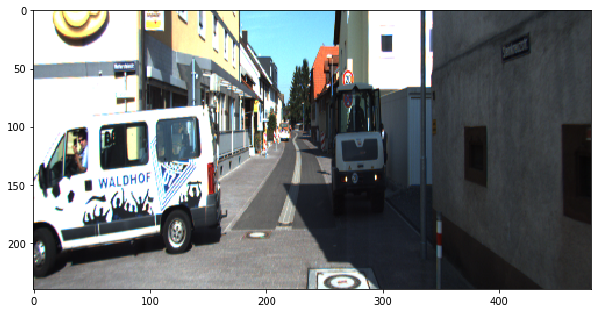

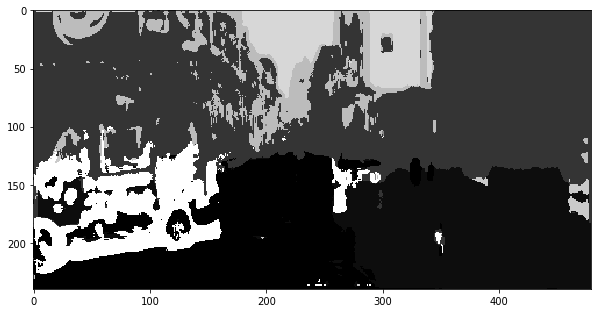

In [4]:
model_dict = torch.load('train-history/trained_model99_dict.pth')
model = UNet(3, 35)
model.load_state_dict(model_dict)
model.eval()
model = model.cpu()
seg, _ = showSegModelInference(model, "images/example2.png", display=True)
print(np.unique(seg))